In [1]:
from sklearn import model_selection,naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict


from bs4 import BeautifulSoup

import re
import os,stat
import email
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import matplotlib
import jieba.posseg as pseg

In [2]:
warnings.filterwarnings('ignore')

 1. 邮件读取与数据预处理 <br />
 2. TF-IDF向量化 <br />
 3. 关键词分析 <br />
 4. 垃圾邮件分类 <br />
 5. 非垃圾邮件聚类&分类 <br />

### Functions

In [3]:
def get_from(msg):
    '''
    获取message的发件人信息
    :param: email的message对象
    :return:发件人名字或地址
    '''
    return email.utils.parseaddr(msg.get('from'))[1]

In [4]:
def read_file(filename):
    '''
    从email文件读出邮件内容，需要使用 email 解析
    :param: filename: email文件路径名
    :return: 邮件主题和邮件内容字符串, 可能带 html 格式
    '''
    with open(filename, encoding='latin-1') as fp:
        msg = email.message_from_file(fp)
        payload = msg.get_payload()
        if type(payload) == type(list()):
            payload = payload[0]
        if type(payload) != type(''):
            payload = str(payload)
            
        sub = msg.get('subject')
        sub = str(sub)
        return sub ,payload,get_from(msg)

In [5]:
def clean_html(raw_html):
    '''
    清除邮件内容中的 html 标签
    :param raw_html: 带 html 标签的文本内容
    :return: 不带 html 标签的文本内容
    '''
    return BeautifulSoup(raw_html, 'html.parser').text

In [6]:
def top_mean_feats(X, features,x_range=None, min_tfidf=0.15, top_n=10):
    '''
    获取给定下标的邮件的关键词
    :param X: 邮件文本array
    :param features: list of all the tokens
    :param x_range: 一个邮件下标，或者一组邮件下标
    :param min_tfidf: threshold of tfidf. If the value of tfidf is lower than min_tfidf, it will be set to 0.
    :param top_n: number of keywords 需要获取排名前多少的关键词
    :return: dataframe - col1 排名前n的关键词，col2 the score of each keyword
    '''
    if x_range:
        D = X[x_range].toarray()
    else: # 如果没有给定的邮件下标，就获取所有邮件
        D = X.toarray()
        
    #若数组中某元素的tfidf分小于阈值则将它变成0
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)#对2维数组D按列取平均，变成1行，1万9千多列的数组
    topn_ids = np.argsort(tfidf_means)[::-1][:top_n]
    top_feats = [(features[i], tfidf_means[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

In [7]:
def docToWords(doc,stopwords=None):
    """
    use the stopwords to spilit the document into words
    :param doc: text
    :param stopwords: stopwords filepath
    :return: list of words
    """
    text=doc
    text=text.split('\n')
    stopword=stopwords
    #split text into sentence array
    seprators='.?!;？！。；…'
    for sep in seprators:
        res=[]
        for sentence in text:
            res+=(sentence.split(sep))
        text=res
    
    #use jieba to do participle
    res=[]
    for sentence in text:
        #participle
        sentence=pseg.cut(sentence)
        sentence=    [w for w in sentence]
        #去除前后空格和非语素字
        sentence=[w.word.strip() for w in sentence if w.flag != 'x']
        #去除空字符
        sentence=[word for word in sentence if len(word) > 0]
        #去除停用词
        if stopwords!=None:
            sentence=[w for w in sentence if w not in stopword]
        res.append(sentence)
    return res

In [8]:
def get_acc(clf, train_X, train_y, test_X,test_y):
    # 模型对训练集进行训练
    clf.fit(train_X, train_y)
    # 模型对测试集进行预测
    predictions = clf.predict(test_X)
    return metrics.accuracy_score(predictions, test_y)

In [36]:
def print_tfidf_topn(X,features,top_n=10):
    '''
    tfidf关键词的打印方法
    :param: X:tfidf向量
    :param: features:词语列表
    :param: top_n:关键词个数，默认为10
    :return: word-tfidf dataframe
    '''
    X = X.toarray()
    means = np.mean(X, axis=0)#对2维数组X按列取平均,计算每个词在所有邮件中的平均tfidf值
    idx = np.argsort(means)[::-1][:top_n]
    res = [(features[i], means[i]) for i in idx]
    df = pd.DataFrame(res, columns=['features', 'tfidf'])
    for f,m in res:
        print(f+':'+str(m))
    return df

In [39]:
def KFoldMean(X,y,clf):
    pred=cross_val_predict(clf,X,y,cv=10)
    bac=metrics.balanced_accuracy_score(y,pred)
    return bac

以下两个函数是为了试验textrank。运用textrank找到了关键词，但没有参与之后的classification

In [9]:
def combine(word_list, window=2):
    """
    构造在window下的单词组合，用来构造单词之间的边。(sliding window algorithm?)
    :param word_list: list of str, 由单词组成的列表。
    :param windows: int, 窗口大小。
    """
    if window < 2: window = 2
    for x in range(1, window):
        if x >= len(word_list):
            break
        word_list2 = word_list[x:]
        #利用zip方法，yield生成一对词构成的边
        res = zip(word_list, word_list2)
        for r in res:
            yield r

In [10]:
def get_keywords(txt,stopwords,window=2,m=10):
    if txt.endswith('.txt'):
        words=txtToWords(txt,stopwords)
    else:
        words=docToWords(txt,stopwords)
    t_trans_mat = []
    result_words=[]
    result_prob=[]
    #从词查下标的字典
    word_index = {}
    #从下标查词的字典
    index_word = {}
    words_number = 0
    
    #以下将把words列表中所有词统计到VSM（向量空间模型）中，并提供词到下标，下标到词两个字典方便后续查找。
    for word_list in words:
        for word in word_list:
            if not word in word_index:
                word_index[word] = words_number
                index_word[words_number] = word
                words_number += 1

    #以下根据每个词出现的位置信息建立无向权重图
    graph =  np.zeros((words_number,words_number))
    #如果两个词出现在同一个句子中，符合窗口大小关系，则在它们之间建立一条边，并存入图中。
    for word_list in words:
        for w1, w2 in combine(word_list, window):
            if w1 in word_index and w2 in word_index:
                index1 = word_index[w1]
                index2 = word_index[w2]
                graph[index1][index2] += 1.0
                graph[index2][index1] += 1.0
    
    #在graph中获取前m个关键词词的下标，然后在index_word字典中查到词，存入result_words中返回
    w_prob=np.array(np.mean(graph,axis=0))
    w_prob_rank=np.argsort(-w_prob)
    for i in range(m):
        result_words.append(index_word[w_prob_rank[i+1]])
        result_prob.append(w_prob[w_prob_rank[i+1]])
    return result_words,result_prob

### Main

#### 1. preprocessing

把每条邮件的标签（0代表垃圾邮件,1代表非垃圾邮件）读到y中。

In [11]:
labels = pd.read_csv('spam-mail.tr.label')
y=labels['Prediction']
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Prediction, dtype: int64

In [12]:
count=0
pathname = 'TR'
filelist=os.listdir(pathname)
filelist.sort(key= lambda x:int(x[6:-4]))
    
IDs=[]
Bodys=[]
Froms=[]
for file in filelist:
    fpath = os.path.join(pathname, file)
    info = os.stat(fpath)
    # if it's an regular file and is an email
    if stat.S_ISREG(info.st_mode) and file.endswith('.eml'):
        '''
        1. 从邮件文件出读出所有文本
        2. 对邮件正文进行清理并保存
        '''
        sub,text,from_u=read_file(fpath)
        text = clean_html(text)
        IDs.append(str(count))
        Bodys.append(str(sub+text))
        Froms.append(str(from_u))
        count+=1
            
raw_data=pd.DataFrame({'ID':IDs,'Body':Bodys,'From':Froms})
X = raw_data['Body']

将数据集划分为训练集和测试集合

In [13]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, random_state=3, train_size=0.7)

#### 2. TF-IDF

In [14]:
stopwords = ENGLISH_STOP_WORDS.union(['20', 'org', 'com', 'net','www','2002','2009','2010','ur','http','2','E','D','22','Re','The','just'])

把原始文本转化成TF-IDF特征矩阵,先拟合数据，再标准化

In [15]:
vect = TfidfVectorizer(stop_words=stopwords, max_df=0.50, min_df=2)
X = vect.fit_transform(X)

In [16]:
train_X=vect.transform(train_X)
test_X=vect.transform(test_X)

In [17]:
#this gives you the list of all the tokens or n-grams or words
features = vect.get_feature_names()

In [18]:
#利用tfidf计算下标为num这封邮件排名前10的关键词
print('\n关键词分析(tfidf)...')
num=1
top_n=10
print('\n邮件TRAIN_%d.eml的top %d keywords(tfidf):'%(num+1,top_n))
print(top_mean_feats(X,features,x_range=num,top_n=top_n))


关键词分析(tfidf)...

邮件TRAIN_2.eml的top 10 keywords(tfidf):
      features     score
0       webcam  0.469939
1  girlfriends  0.263913
2    inbetween  0.246464
3    personals  0.240235
4        wanna  0.240235
5     sexually  0.240235
6        teens  0.234970
7        horny  0.230408
8       eating  0.226385
9         baby  0.208935


In [19]:
#利用tfidf计算所有邮件排名前10的关键词
print('\n所有邮件的top %d keywords(tfidf):'%top_n)
print(top_mean_feats(X, features,top_n=top_n))
    
raw=raw_data['Body']
data=''
count=0
for r in raw:#构建字符串
    count+=1
    if count%20!=0:
        continue
    data+=r



所有邮件的top 10 keywords(tfidf):
       features     score
0        debian  0.037543
1         linux  0.011911
2         razor  0.009595
3           kde  0.009428
4          ilug  0.008613
5          spam  0.008552
6  spamassassin  0.008327
7           rpm  0.008281
8         lists  0.007444
9          java  0.007233


In [20]:
#获得textrank方法排名前10的关键词及其评分
print('\n关键词分析(TextRank)...')
w,p=get_keywords(data,stopwords,m=top_n)
print('\n所有邮件的top %d keywords(TextRank):'%top_n)
for i in range(len(w)):
    print(w[i]+':'+str(p[i]))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wang1\AppData\Local\Temp\jieba.cache



关键词分析(TextRank)...


Loading model cost 0.954 seconds.
Prefix dict has been built succesfully.



所有邮件的top 10 keywords(TextRank):
lists:0.01729496014052155
email:0.01634914200783678
use:0.015403323875152006
list:0.013376570733684636
user:0.012700986353195514
text:0.012160518848804215
C:0.011890285096608567
time:0.01080935008782597
debian:0.01053911633563032
mailing:0.010133765707336847


In [21]:
print('\nNaive Bayes accuracy score：')
print(get_acc(naive_bayes.MultinomialNB(),train_X, train_y, test_X,test_y))
print('\nSVM accuracy score：')
print(get_acc(svm.SVC(kernel = 'linear'),train_X, train_y, test_X,test_y))


Naive Bayes accuracy score：
0.9346666666666666

SVM accuracy score：
0.976


非垃圾邮件的聚类

In [31]:
#获得所有非垃圾邮件的下标
idx=[i for i,label in enumerate(y) if label==1]

In [32]:
X_c=X[idx]
y_c=y[idx].values

In [33]:
#把数据转化成numpy的矩阵,方便后面的PCA操作
X_dense = X_c.todense()
#把数据降维成2，方便以图形方式展示数据
coords = PCA(n_components=2).fit_transform(X_dense)

In [34]:
#聚类clustering
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1,random_state=20)
labels = clf.fit_predict(X_c)

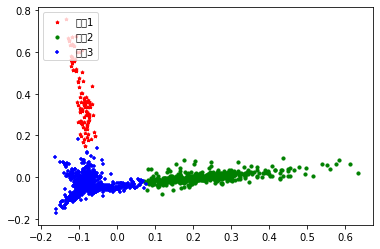

In [35]:
#下面绘制3个cluster点的散点图
l1=np.squeeze(np.where(labels==0))
l2=np.where(labels==1)
l3=np.where(labels==2)
plt.figure(1)
ax = plt.subplot(111)
p1=ax.scatter(coords[l1,0],coords[l1,1],marker = '*',color = 'r',label='1',s=10)
p2=ax.scatter(coords[l2,0],coords[l2,1],marker = 'o',color = 'g',label='2',s=10)
p3=ax.scatter(coords[l3,0],coords[l3,1],marker = '+',color = 'b',label='3',s=10)
ax.legend((p1, p2, p3), (u'类别1', u'类别2', u'类别3'), loc=2)
    
plt.show()

In [38]:
print('\n关键词分析(tfidf)...')
print('\ncluster 1 top 10 keywords(tfidf):')
print_tfidf_topn(X[l1],features)
print('\ncluster 2 top 10 keywords(tfidf):')
print_tfidf_topn(X[l2],features)
print('\ncluster 3 top 10 keywords(tfidf):')
print_tfidf_topn(X[l3],features)
print('')


关键词分析(tfidf)...

cluster 1 top 10 keywords(tfidf):
debian:0.03763538786512196
lists:0.031829885857343386
spam:0.029953639231665496
list:0.022353230431631947
unsubscribe:0.019834317334170192
wrote:0.0188263287223026
linux:0.018804703721456352
email:0.018782065264704353
spamassassin:0.0186445989918691
click:0.01653120824062853

cluster 2 top 10 keywords(tfidf):
debian:0.04828552351932212
lists:0.03279952923288766
unsubscribe:0.024577286743963592
email:0.018579216786144787
list:0.017294105513503508
click:0.017113223767854752
linux:0.016417828248621206
use:0.015327623097057628
spam:0.014838588038104287
content:0.013804825338650987

cluster 3 top 10 keywords(tfidf):
debian:0.04191630949180041
lists:0.03247384898736442
unsubscribe:0.022248103854794764
list:0.020156161560015807
email:0.01930265923218262
click:0.0164712460436056
linux:0.015871789727806073
wrote:0.015654375414942134
spam:0.014307841604514754
users:0.014190604150183963



cross_val_predict自动对X,y进行训练测试集的划分并获取平均的预测结果，有了预测结果pred就可以计算得到精度bac

In [40]:
 y_temp=y_c
y_temp[:]=0
y_temp[l3]=1
print('\nNaive Bayes训练、预测、获取精度...')
b_nb=KFoldMean(X_c,y_temp,naive_bayes.MultinomialNB())
print('\n对非垃圾邮件聚类打标签后，Naive Bayes分类模型精度：'+str(b_nb))
print('\nSVM训练、预测、获取精度...')
b_svm=KFoldMean(X_c,y_temp,svm.SVC(kernel = 'linear'))
print('\n对非垃圾邮件聚类打标签后，SVM分类模型精度：'+str(b_svm))


Naive Bayes训练、预测、获取精度...

对非垃圾邮件聚类打标签后，Naive Bayes分类模型精度：0.941023956270398

SVM训练、预测、获取精度...

对非垃圾邮件聚类打标签后，SVM分类模型精度：0.9871959194753435
